In [11]:
!pip3 install datasets

  Obtaining dependency information for datasets from https://files.pythonhosted.org/packages/66/f8/38298237d18d4b6a8ee5dfe390e97bed5adb8e01ec6f9680c0ddf3066728/datasets-2.14.4-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow>=8.0.0 from https://files.pythonhosted.org/packages/9b/33/6d89309477d372604e95d6b7dc1160d8d5748cadf3913c996529e8e78cf4/pyarrow-13.0.0-cp310-cp310-manylinux_2_28_aarch64.whl.metadata
  Obtaining dependency information for dill<0.3.8,>=0.3.0 from https://files.pythonhosted.org/packages/f5/3a/74a29b11cf2cdfcd6ba89c0cecd70b37cd1ba7b77978ce611eb7a146a832/dill-0.3.7-py3-none-any.whl.metadata
  Obtaining dependency information for xxhash from https://files.pythonhosted.org/packages/83/55/3c89945f5d21791935e732d06e8bd383b367b47af3a9e09c3fa5c945f27e/xxhash-3.3.0-cp310-cp310-manylinux_2_17_aarch64.manylinux2014_aarch64.whl.metadata
  Obtaining dependency information for multiprocess from https://files.pythonhosted.org/packages/35/a8/36d8d7b3e46b377800

In [2]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import torch
from peft import get_peft_model, LoraConfig, TaskType, get_peft_model_state_dict, get_peft_config

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import os
import random
import json
import re
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

# dataset,import load_dataset, load_metric
from datasets import load_dataset, load_metric

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# DICT_PATH = '/app/data/MiniProj/models'
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DICT_PATH = r'/content/drive/MyDrive/ml/MiniProj/Models'
    DATA_PATH = r'/content/drive/MyDrive/msl/MiniProj/Datas'
except:
    DICT_PATH = r'/app/data/models'
    DATA_PATH = r'/app/data/datas'

In [26]:
df = pd.read_csv('./news_sentiment_dataset')
df

,content,sentiment
0,"Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로...",neutral
1,테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평...,neutral
2,"국제 전자산업 회사인 엘코텍은 탈린 공장에서 수십 명의 직원을 해고했으며, 이전의 ...",negative
3,새로운 생산공장으로 인해 회사는 예상되는 수요 증가를 충족시킬 수 있는 능력을 증가...,positive
4,"2009-2012년 회사의 업데이트된 전략에 따르면, Basware는 20% - 4...",positive
...,...,...
12459,코로나 충격에 따른 근로 시간 감소_ 과거 위기의 5배,negative
12460,7월 사업체종사자 13만8천명 감소 코로나19 여파에 5개월째 감소,negative
12461,한치 앞도 안보인다..채용문 꽁꽁 닫는 카드사,negative
12462,토스_ 고객 상담직 신입 및 경력 30명 공개 채용,positive


In [27]:
# sentiment 종류별 개수
df['sentiment'].value_counts()

sentiment
positive    4870
negative    4007
neutral     3587
Name: count, dtype: int64

In [5]:
class FinBertKR:
    def __init__(self):
        model_name = "snunlp/KR-FinBert-SC"
        self.__tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.__model = AutoModelForSequenceClassification.from_pretrained(model_name)
        self.__model.to(DEVICE)
        self.__softmax = F.softmax
        
    def load_dict(self, model_name):
        self.__model.load_state_dict(torch.load(f'{DICT_PATH}/{model_name}'))

    def get_sentiment(self, text):
        inputs = self.__tokenizer(text, return_tensors='pt').to(DEVICE)
        outputs = self.__model(**inputs)
        probs = self.__softmax(outputs.logits, dim=1)
        pred = self.__model.config.id2label[probs.argmax().item()]
        return pred

In [6]:
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)

In [7]:
MODEL_NAME = "snunlp/KR-FinBert-SC"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
model_orig = model
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

trainable params: 299,526 || all params: 101,700,870 || trainable%: 0.2945166545772912


In [8]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

inputs = tokenizer("Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다.", return_tensors='pt', padding=True, truncation=True, max_length=128, pad_to_max_length=True)
inputs2 = tokenizer("테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.", return_tensors='pt', padding=True, truncation=True, max_length=128, pad_to_max_length=True)
inputs, inputs2

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2416: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


({'input_ids': tensor([[    2,    43,  5328, 10178,  5051, 10053,    16,  2078, 17805, 14243,
          10384,  8455,  8494, 14275,  8482,    16,  8703,  9716,  5008,  9873,
           5016,  3625,  5131,  9714,  5022, 10019,  8544,    18,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1]])},
 {'input_ids': tensor([[    2,  4317,  5356,  5287,  5723, 11409,  5035, 13509,  9285,  5138,
          12706, 11735,  8454, 12067,  9188,  8569, 10236,  8591,  8682, 18121,
           4444,  5112, 10272, 12945,  2860, 11009, 15239,  8519,  9481,  5088,
           9714,  8589,  3254, 10784,  9192,    18,     3]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
inputs = [
    "Gran에 따르면, 그 회사는 회사가 성장하고 있는 곳이지만, 모든 생산을 러시아로 옮길 계획이 없다고 한다.",
    "테크노폴리스는 컴퓨터 기술과 통신 분야에서 일하는 회사들을 유치하기 위해 10만 평방미터 이상의 면적을 단계적으로 개발할 계획이라고 성명은 밝혔다.",
    "이번 주에는 새로운 노트북이 출시되었다.",
    ]
inputs = tokenizer(inputs, return_tensors='pt', padding=True, truncation=True, max_length=128, pad_to_max_length=True)
model.to(DEVICE)
outputs = model(
    input_ids=inputs['input_ids'].to(DEVICE),
    attention_mask=inputs['attention_mask'].to(DEVICE),
    labels=torch.tensor([0, 1, 0]).to(DEVICE)
)
preds = outputs.logits.argmax(dim=1)
preds = preds.cpu().numpy()
pred_class = [model.config.id2label[pred] for pred in preds]
inputs, outputs, preds, pred_class

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2416: UserWarning: Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.
  warnings.warn("Though `pad_to_max_length` = `True`, it is ignored because `padding`=`True`.")


({'input_ids': tensor([[    2,    43,  5328, 10178,  5051, 10053,    16,  2078, 17805, 14243,
          10384,  8455,  8494, 14275,  8482,    16,  8703,  9716,  5008,  9873,
           5016,  3625,  5131,  9714,  5022, 10019,  8544,    18,     3,     0,
              0,     0,     0,     0,     0,     0,     0],
         [    2,  4317,  5356,  5287,  5723, 11409,  5035, 13509,  9285,  5138,
          12706, 11735,  8454, 12067,  9188,  8569, 10236,  8591,  8682, 18121,
           4444,  5112, 10272, 12945,  2860, 11009, 15239,  8519,  9481,  5088,
           9714,  8589,  3254, 10784,  9192,    18,     3],
         [    2,  8632,  3890,  8540,  9973, 17214,  5364,  5022, 12213,  9305,
             18,     3,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
              0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

AttributeError: 'SequenceClassifierOutput' object has no attribute 'backward'

In [125]:
class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        
        # sentiment label -> 'positive': 0, 'natural': 1, 'negative': 2
        self.label_map = {'positive': 0, 'neutral': 1, 'negative': 2}
        
        contents = df['content'].tolist()
        labels = df['sentiment'].tolist()
        
        self.contents_encoded = self.tokenizer(
            contents,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_len,
        )
        
        self.labels_encoded = torch.tensor([self.label_map[label] for label in labels])

    def __len__(self):
        return len(self.labels_encoded)

    def __getitem__(self, idx):
        
        X = {
            'input_ids': self.contents_encoded['input_ids'][idx],
            'attention_mask': self.contents_encoded['attention_mask'][idx],
            'token_type_ids': self.contents_encoded['token_type_ids'][idx],
        }
        
        y = self.labels_encoded[idx]
        
        return X, y

In [126]:
df = pd.read_csv(os.path.join(DATA_PATH, 'news_sentiment_dataset'))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
max_len = 128
batch_size = 32
epochs = 10
lr = 1e-5
seed = 42

news_dataset = NewsDataset(df, tokenizer, max_len)
train_valid_dataset, test_dataset = train_test_split(news_dataset, test_size=0.2, random_state=seed)
tarin_dataset, valid_dataset = train_test_split(train_valid_dataset, test_size=0.2, random_state=seed)

In [127]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

iterloader = iter(test_loader)

batch_1 = next(iterloader)
batch_2 = next(iterloader)
batch_1, batch_2

([{'input_ids': tensor([[    2,  3623,  3209,  ...,     0,     0,     0],
           [    2,    63, 13977,  ...,     0,     0,     0],
           [    2,    41,  5556,  ...,     0,     0,     0],
           ...,
           [    2,  9496,  5091,  ...,     0,     0,     0],
           [    2, 18901,  5019,  ...,     0,     0,     0],
           [    2,  8473,  8552,  ...,     0,     0,     0]]),
   'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           ...,
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0],
           [1, 1, 1,  ..., 0, 0, 0]]),
   'token_type_ids': tensor([[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]])},
  tensor([2, 2, 0, 2, 2, 1, 0, 1, 0, 0, 1, 0, 2, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 1,
    

In [71]:
num_2_label = {0: 'positive', 1: 'neutral', 2: 'negative'}

import time

model.to(DEVICE)
model_orig.to(DEVICE)
model.eval()

lora_times = []
orig_times = []

for i in range(50):
    lora_time_start = time.time()
    
    inputs, label = tarin_dataset[i]
    outputs = model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)
    pred = model.config.id2label[probs.argmax().item()]
    
    lora_time_end = time.time()
    orig_time_start = time.time()
    
    outputs_orig = model_orig(**inputs)
    probs_orig = F.softmax(outputs_orig.logits, dim=1)
    pred_orig = model_orig.config.id2label[probs_orig.argmax().item()]
    
    orig_time_end = time.time()
    
    print(f'pred: {pred}, pred_orig: {pred_orig}, label: {num_2_label[label]}')
    lora_times.append(lora_time_end - lora_time_start)
    orig_times.append(orig_time_end - orig_time_start)

print(f'average lora time: {np.mean(lora_times):.2f}, average orig time: {np.mean(orig_times):.2f}')
    
# with torch.no_grad():
#     inputs, label = tarin_dataset[1000]
#     inputs.to(DEVICE)
#     outputs = model(**inputs)
#     probs = F.softmax(outputs.logits, dim=1)
#     pred = model.config.id2label[probs.argmax().item()]
#     print(pred, num_2_label[label])

pred: positive, pred_orig: positive, label: positive
pred: positive, pred_orig: positive, label: positive
pred: positive, pred_orig: positive, label: neutral
pred: neutral, pred_orig: neutral, label: neutral
pred: neutral, pred_orig: neutral, label: neutral
pred: neutral, pred_orig: neutral, label: neutral
pred: positive, pred_orig: positive, label: positive
pred: neutral, pred_orig: neutral, label: positive
pred: neutral, pred_orig: neutral, label: neutral
pred: neutral, pred_orig: neutral, label: negative
pred: neutral, pred_orig: neutral, label: positive
pred: neutral, pred_orig: neutral, label: positive
pred: negative, pred_orig: negative, label: negative
pred: neutral, pred_orig: neutral, label: negative
pred: neutral, pred_orig: neutral, label: neutral
pred: positive, pred_orig: positive, label: neutral
pred: neutral, pred_orig: neutral, label: negative
pred: neutral, pred_orig: neutral, label: positive
pred: neutral, pred_orig: neutral, label: neutral
pred: negative, pred_orig: 

# 여기부터 돌리면 됩니다

In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F
import torch
from peft import get_peft_model, LoraConfig, TaskType, get_peft_model_state_dict, get_peft_config

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import os
import random
import json
import re
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, precision_recall_curve, average_precision_score, f1_score, accuracy_score, precision_score, recall_score, matthews_corrcoef, balanced_accuracy_score, cohen_kappa_score
from sklearn.model_selection import StratifiedKFold

# dataset,import load_dataset, load_metric
from datasets import load_dataset, load_metric

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# DICT_PATH = '/app/data/MiniProj/models'
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DICT_PATH = r'/content/drive/MyDrive/ml/MiniProj/Models'
    DATA_PATH = r'/content/drive/MyDrive/msl/MiniProj/Datas'
except:
    DICT_PATH = r'/app/data/models'
    DATA_PATH = r'/app/data/datas'

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
NUM2LABEL = {2: 'positive', 1: 'neutral', 0: 'negative'}
LABEL2NUM = {'positive': 2, 'neutral': 1, 'negative': 0}

class NewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.tokenizer = tokenizer
        
        self.label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
        
        contents = df['content'].tolist()
        labels = df['sentiment'].tolist()
        
        self.contents_encoded = self.tokenizer(
            contents,
            return_tensors='pt',
            padding=True,
            truncation=True,
            max_length=max_len,
        )
        
        self.labels_encoded = torch.tensor([self.label_map[label] for label in labels])

    def __len__(self):
        return len(self.labels_encoded)

    def __getitem__(self, idx):
        
        X = {
            'input_ids': self.contents_encoded['input_ids'][idx],
            'attention_mask': self.contents_encoded['attention_mask'][idx],
            'token_type_ids': self.contents_encoded['token_type_ids'][idx],
        }
        
        y = self.labels_encoded[idx]
        
        return X, y
    
    
class EarlyStopping():
    def __init__(self, patience=10, save_path=None, target_score=0, model_name='lora'):
        # 초기화
        self.best_score = 0
        self.patience_count = 0
        self.target_score = target_score
        self.patience = patience
        self.save_path = save_path
        self.datetime = time.strftime
        self.model_name = model_name
    # 얼리 스토핑 여부 확인 함수 정의
    def is_stop(self, model, score, epoch):
        # 모델 저장(마지막 모델)
        self.__save_last_model(model)
        # 스코어가 타겟 스코어보다 낮을 경우
        if score < self.target_score:
            # patience 초기화
            self.patience_count = 0
            return False
        
        # 스코어가 이전보다 좋을 경우
        if self.best_score < score:
            # 스코어를 업데이트
            self.best_score = score
            # 모델 저장
            self.__save_best_model(model, epoch)
            # patience 초기화
            self.patience_count = 0
            return False
        
        # 스코어가 이전보다 좋지 않을 경우 +
        # 스코어가 타겟 스코어보다 높을 경우
        # patience 증가
        self.patience_count += 1
        # patience가 최대치를 넘을 경우
        if self.patience_count > self.patience:
            return True
        # patience가 최대치를 넘지 않을 경우
        return False
    # 모델 저장 함수 정의
    def __save_best_model(self, model, epoch):
        model_name = '{}_model_best_{}/'.format(self.model_name, f'ephoc_{epoch:03}')
        # torch.save(model.state_dict(), self.save_path + model_name)
        model.save_pretrained(self.save_path + model_name)
    # 마지막 모델 저장 함수 정의
    def __save_last_model(self, model):
        model_name = '{}_model_last_{}/'.format(self.model_name, 'ephoc_last')
        # torch.save(model.state_dict(), self.save_path + model_name)
        model.save_pretrained(self.save_path + model_name)
        

######################
# 학습 함수 정의
######################
def train_loop(dataloader, model, loss_fn, optimizer, tqdmbar=None):
    is_tqdm = True
    if tqdmbar is None:
        is_tqdm = False
    if is_tqdm:
        tqdmbar.set_description('train')
    # 손실값 초기화
    loss_list = []
    score_list = []
    # 모델을 학습 모드로 설정
    model.train()
    
    total_batch_num = len(dataloader)
    batch_num = 0
    # 배치 단위로 학습
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        y = y.to(DEVICE)
        # 모델을 통해 예측
        output = model(
            input_ids=X['input_ids'].to(DEVICE),
            attention_mask=X['attention_mask'].to(DEVICE),
            token_type_ids=X['token_type_ids'].to(DEVICE),
        )
        output = output.logits
        pred = output.argmax(dim=1)
        # 손실값 계산
        loss = loss_fn(output, y)
        # 기울기 초기화
        optimizer.zero_grad()
        # 역전파
        loss.backward()
        # 가중치 업데이트
        optimizer.step()
        # 손실값을 리스트에 저장
        loss_list.append(loss.item())
        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
        
        if is_tqdm:
            batch_num += 1
            desc_txt = f'train batch: {batch_num}/{total_batch_num}, loss: {loss.item():.4f}, score: {score_list[-1]:.4f}'
            tqdmbar.set_description(desc_txt)
        
    # 손실값 평균 계산
    loss_mean = np.mean(loss_list)
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    # 손실값 평균, 정확도 평균 반환
    return loss_mean, score_mean

######################
# 평가 함수 정의
######################
@torch.inference_mode()
def test_loop(dataloader, model, tqdmbar=None):
    is_tqdm = True
    if tqdmbar is None:
        is_tqdm = False
    if is_tqdm:
        tqdmbar.set_description('test')
        
    # 저장값 초기화
    score_list = []
    # 모델을 평가 모드로 설정
    model.eval()
    
    total_batch_num = len(dataloader)
    batch_num = 0
    # 배치 단위로 평가
    for X, y in dataloader:
        # 데이터를 디바이스에 할당
        y = y.to(DEVICE)
        # 모델을 통해 예측
        output = model(
            input_ids=X['input_ids'].to(DEVICE),
            attention_mask=X['attention_mask'].to(DEVICE),
            token_type_ids=X['token_type_ids'].to(DEVICE),
        )
        
        output = output.logits
        # 예측값을 클래스로 변환
        pred = output.argmax(dim=1)
        # 정확도를 리스트에 저장
        score_list.append(accuracy_score(pred.cpu().detach().numpy(),
                                        y.cpu().numpy(),
                                        ))
        
        if is_tqdm:
            batch_num += 1
            desc_txt = f'test batch: {batch_num}/{total_batch_num}, score: {score_list[-1]:.4f}'
            tqdmbar.set_description(desc_txt)
            
    # 정확도 평균 계산
    score_mean = np.mean(score_list)
    # 정확도 평균 반환
    return score_mean

######################
# epoch 학습 함수 정의
######################
def epoch_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer, tqdmbar=None):
    # 학습
    train_loss, train_score = train_loop(train_dataloader, model, loss_fn, optimizer, tqdmbar)
    # 평가
    valid_score = test_loop(valid_dataloader, model, tqdmbar)
    # 손실값 평균, 정확도 평균 반환
    return train_loss, train_score, valid_score

In [3]:
######################
# 상수 선언
######################
# 배치 사이즈
batch_size = 128
# 에폭 수
epochs = 80
# 학습률
lr = 1e-5
# 시드값
seed = 42
# 장비 설정
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
# 모델 경로
MODEL_NAME = "snunlp/KR-FinBert-SC"
# 최대 길이
MAX_LEN = 128

#######################
# 데이터셋, 데이터로더 생성
#######################
df = pd.read_csv(os.path.join(DATA_PATH, 'news_sentiment_dataset'))
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
# 데이터셋 생성
news_dataset = NewsDataset(df, tokenizer, MAX_LEN)
# 데이터셋 분할
tv_dataset, test_dataset = train_test_split(news_dataset, test_size=0.2, random_state=seed)
train_dataset, valid_dataset = train_test_split(tv_dataset, test_size=0.2, random_state=seed)
# 데이터로더 생성
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

#######################
# 모델 생성
#######################
# 모델 생성
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
# lora config 생성
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)
# lora 모델 생성
model = get_peft_model(model, peft_config)
# 모델을 장비에 할당
model.to(DEVICE)
# 손실함수 생성
loss_fn = torch.nn.CrossEntropyLoss()
# 옵티마이저 생성
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
# 얼리 스토핑 생성
early_stopping = EarlyStopping(patience=10, save_path=SAVE_PATH, target_score=0.8, model_name='lora')

In [4]:
print('DEVICE : {}'.format(DEVICE))

DEVICE : cuda


In [5]:
orig_score = test_loop(test_dataloader, model)

In [6]:
print('orig_score : {}'.format(orig_score))

orig_score : 0.38896644467213115


In [7]:
#######################
# 학습
#######################
# 에폭 수 만큼 반복
bar = tqdm(range(epochs))
total_loss = []
total_score = []
total_valid_score = []

for epoch in bar:
    # epoch 학습
    train_loss, train_score, valid_score = epoch_loop(train_dataloader, valid_dataloader, model, loss_fn, optimizer, bar)
    # 얼리 스토핑 체크
    if early_stopping.is_stop(model, valid_score, epoch):
        break
    # 학습 결과 출력
    bar.set_description(f'epoch:{epoch:03} train_loss:{train_loss:.4f} train_score:{train_score:.4f} valid_score:{valid_score:.4f}')
    # 손실값, 정확도 저장
    total_loss.append(train_loss)
    total_score.append(train_score)
    total_valid_score.append(valid_score)

test batch: 16/16, score: 0.8400:  69%|██████▉   | 55/80 [1:16:46<34:53, 83.76s/it]                                 


In [8]:
#######################
# 평가
#######################
# 모델을 평가 모드로 설정
model.eval()
# 평가
test_score = test_loop(test_dataloader, model)
# 평가 결과 출력
print('orig_score: {:.4f}'.format(orig_score))
print('test_score: {:.4f}'.format(test_score))

orig_score: 0.3890
test_score: 0.8027


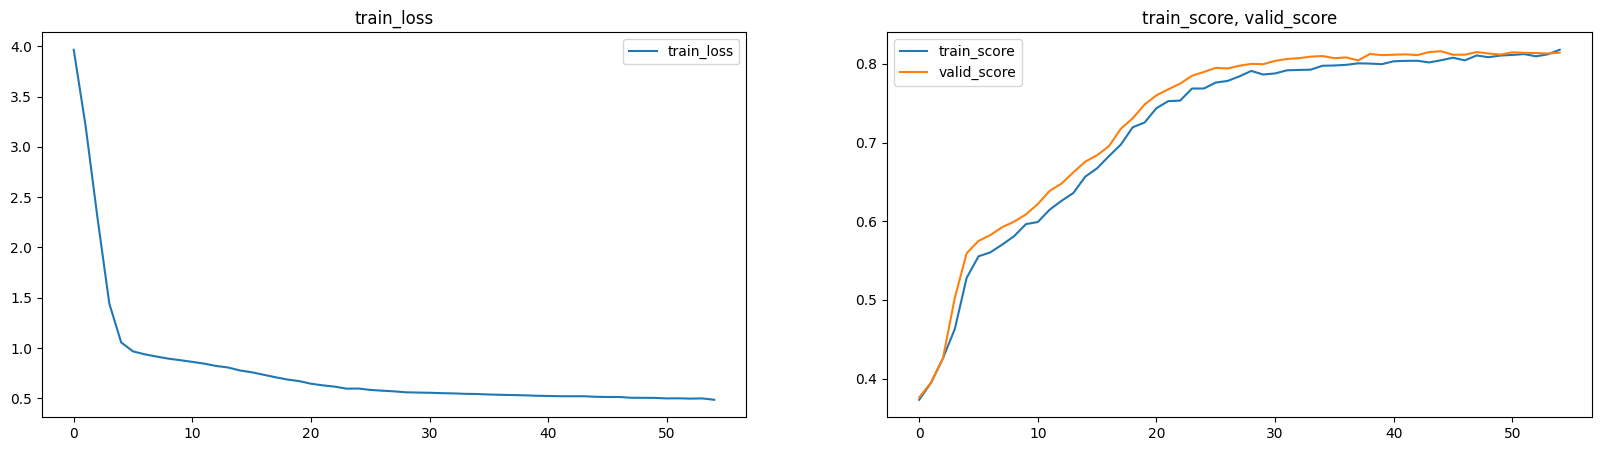

In [9]:
#######################
# train_loss, train_score, valid_score 시각화
#######################
# train_loss, train_score, valid_score 시각화
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot(total_loss, label='train_loss')
ax[0].set_title('train_loss')
ax[0].legend()
ax[1].plot(total_score, label='train_score')
ax[1].plot(total_valid_score, label='valid_score')
ax[1].set_title('train_score, valid_score')
ax[1].legend()
plt.show()

In [25]:
import glob

model_list = glob.glob(SAVE_PATH + '*')
model_list.sort()
model_list

['/app/data/models/lora_model_best_ephoc_028',
 '/app/data/models/lora_model_best_ephoc_030',
 '/app/data/models/lora_model_best_ephoc_031',
 '/app/data/models/lora_model_best_ephoc_032',
 '/app/data/models/lora_model_best_ephoc_033',
 '/app/data/models/lora_model_best_ephoc_034',
 '/app/data/models/lora_model_best_ephoc_038',
 '/app/data/models/lora_model_best_ephoc_043',
 '/app/data/models/lora_model_best_ephoc_044',
 '/app/data/models/lora_model_last_ephoc_last']

In [28]:
from peft import PeftModel, PeftConfig
model_name_or_path = model_list[-1]
peft_model_id = f"{model_name_or_path}_{peft_config.peft_type}_{peft_config.task_type}"

config = PeftConfig.from_pretrained(model_name_or_path)
model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
model = PeftModel.from_pretrained(model, model_name_or_path)

In [16]:
model.load_adapter?

Signature:
model.load_adapter(
    model_id: 'str',
    adapter_name: 'str',
    is_trainable: 'bool' = False,
    **kwargs: 'Any',
)
Docstring: <no docstring>
File:      /usr/local/lib/python3.10/dist-packages/peft/peft_model.py
Type:      method

In [29]:
test_score_list = []
for model_param_dir in model_list:
    config = PeftConfig.from_pretrained(model_param_dir)
    model = AutoModelForSequenceClassification.from_pretrained(config.base_model_name_or_path)
    model = PeftModel.from_pretrained(model, model_param_dir)
    model.to(DEVICE)
    model.eval()
    test_score = test_loop(test_dataloader, model)
    print(model_param_dir, test_score)
    test_score_list.append(test_score)

/app/data/models/lora_model_best_ephoc_028 0.7789126536885246
/app/data/models/lora_model_best_ephoc_030 0.7812179815573771
/app/data/models/lora_model_best_ephoc_031 0.781999231557377
/app/data/models/lora_model_best_ephoc_032 0.7816086065573771
/app/data/models/lora_model_best_ephoc_033 0.7816086065573771
/app/data/models/lora_model_best_ephoc_034 0.7851242315573771
/app/data/models/lora_model_best_ephoc_038 0.7886014344262295
/app/data/models/lora_model_best_ephoc_043 0.7944992315573771
/app/data/models/lora_model_best_ephoc_044 0.795671106557377
/app/data/models/lora_model_last_ephoc_last 0.8027023565573771


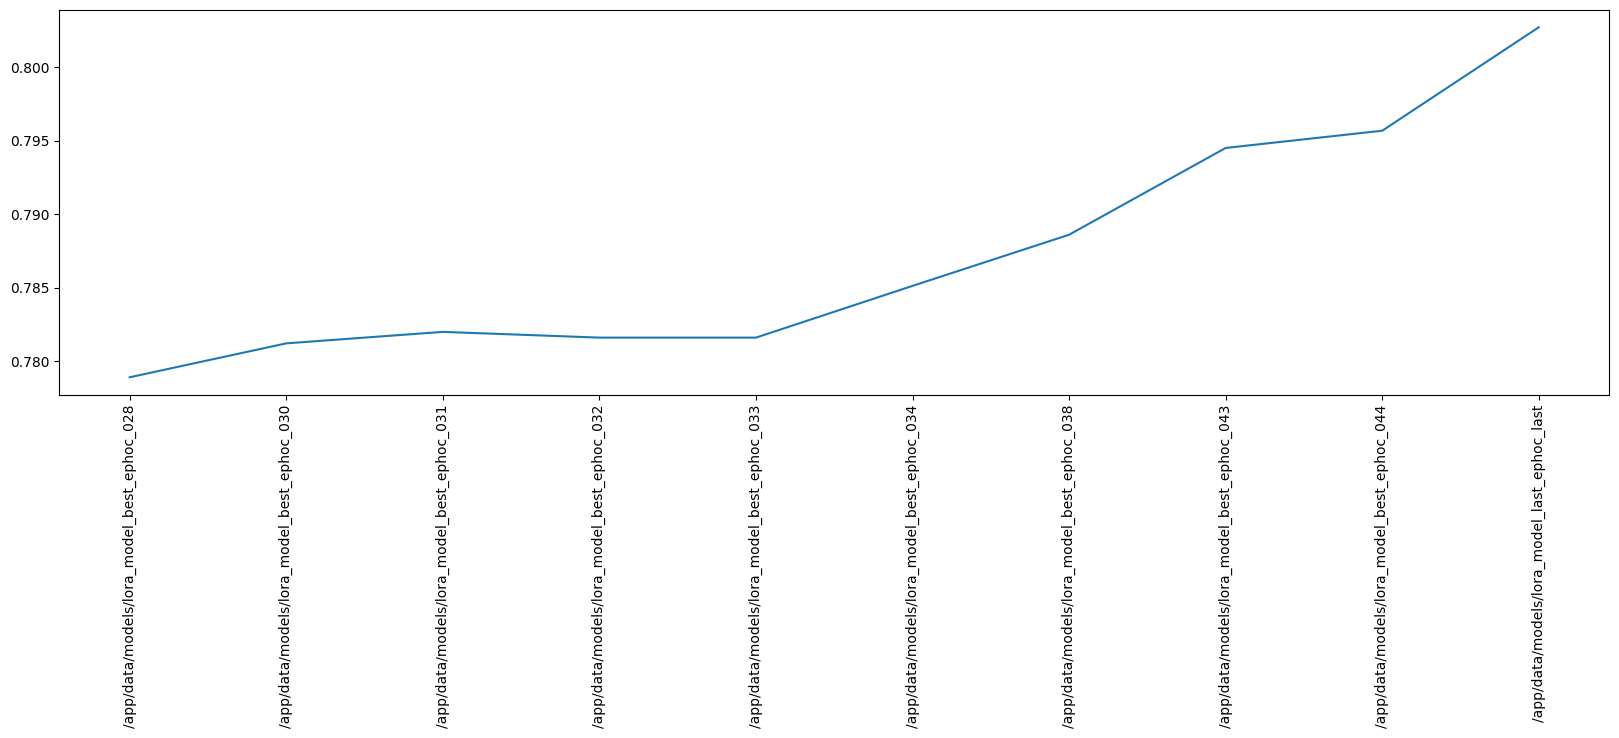

In [30]:
# test_score_list 시각화
# X축에 모델 번호
x = [i for i in range(len(test_score_list))]
# Y축에 정확도
y = test_score_list
# 그래프 생성
plt.figure(figsize=(20, 5))
plt.plot(x, y)
plt.xticks(x, model_list, rotation=90)
plt.show()

In [31]:
# 각 데이터 셋의 길이
print('train_dataset length: {}'.format(len(train_dataset)))
print('valid_dataset length: {}'.format(len(valid_dataset)))
print('test_dataset length: {}'.format(len(test_dataset)))  

train_dataset length: 7976
valid_dataset length: 1995
test_dataset length: 2493


In [44]:
print('--------------trainable parameters--------------')
# 학습 가능한 파라미터 수
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
# 원본 모델의 파라미터 수
print('original model parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))
# lora config 생성
peft_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
)
# lora 모델 생성
model = get_peft_model(model, peft_config)
# lora 모델의 파라미터 수
print('lora model parameters: {}'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

print('\n\n\nlora 모델 print_trainable_parameters()')
model.print_trainable_parameters()

--------------trainable parameters--------------
original model parameters: 101403651
lora model parameters: 299526



lora 모델 print_trainable_parameters()
trainable params: 299,526 || all params: 101,700,870 || trainable%: 0.2945166545772912
